# Using RADICAL-Analytics with RADICAL-Pilot and OSG Experiments

This notebook illustrates the analysis of two experiments performed with RADICAL-Pilot and OSG. The experiments use 4 1-core pilots and between 8 and 64 compute units (CU). RADICAL-Analytics is used to acquire two data sets produced by RADICAL Pilot and then to derive aggregated and per-entity performance measures. 

The state models of RADICAL-Pilot's CU and Pilot entities is presented and all the state-based durations are defined and described. Among these durations, both aggregated and per-entity measures are computed and plotted. The aggregated measures are:

* **TTC**: Total time to completion of the given workload, i.e., between 8 and 64 CU; 
* **TTQ**: Total time spent by the 4 1-core pilots in the OSG Connect queue;
* **TTR**: Total time spent by the four pilots running on their respective work node;
* **TTX**: Total time spent by all the CU executing their kernel.

Each aggregate measure takes into account the time overlap among entities in the same state. For example, if a pilot start running at time t_0, another at time t_0+5s and they both finish at time t_0+100s, TTR will be 100s, not 195s. The same calculation is done for partial, total, and null overlapping.

Single-entity performance measures are derived for each pilot and CU:

* **Tq**: Time spent by a pilot in the queue of the local resource management system (LRMS);
* **Tx**: Time spent by a CU executing its kernel.

The kernel of each CU is a <a href='https://github.com/radical-cybertools/radical.synapse'>Synapse</a> executable emulating a GROMACS execution as specified in the <a href='https://docs.google.com/document/d/1TQrax9iSGovECZZ7wyomVk_LbFjNqeRNCUtEkv7FXfg/edit'>GROMACS/CoCo ENSEMBLES</a> use case. 

We plot and compare these measurements across the two experiments to understand: 

* **How the heterogeneity of OSG resources affects the execution of this type of workload.**
* **Whether queuing time is as dominant as in XSEDE.**

## Table of Content



# Setup

We need to setup both this notebook and the experiment environment. We start with the notebook and then we will move on to the experiment data. 

## Notebook Settings

Display matplotlib diagrams without having to use `plt.show()`.

In [1]:
%matplotlib inline

Load all the Python modules we will use for the analysis. Note that both RADICAL Utils and RADICAL Pilot need to be loaded alongside RADICAL Analytics.

In [2]:
import os
import sys
import glob
import pprint

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:58: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


We configure matplotlib so to produce visually consistent diagrams that look readable and we can directly include in a paper written in LaTeX.

In [3]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color see:
# http://www.tableau.com/about/blog/2016/7/colors-upgrade-tableau-10-56782
# http://tableaufriction.blogspot.com/2012/11/finally-you-can-use-tableau-data-colors.html
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue   [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green  [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red    [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown  [10,11]
             (227, 119, 194), (247, 182, 210), # pink   [12,13]
             (127, 127, 127), (199, 199, 199), # gray   [14,15]
             (188, 189, 34 ), (219, 219, 141), # yellow [16,17]
             (23 , 190, 207), (158, 218, 229)] # cyan   [18,19]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

## Experiment Settings

RADICAL-Pilot save runtime data in two types of file: profiles and databases. Profile files are written by the agent module on the work nodes of the remote resources; database files are stored in the MongoDB instance used for the workload execution. Both types of file need to be retrieved from the remote resource and from the MongoDB instance. Currently, ...

The data used in this notebook are collected in two compressed bzip2 tar archives, one for each experiment dataset. The two archives need to be decompressed into `radical.analytics/use_cases/rp_on_osg/data`. Once unzipped, we acquire the datasets by constructing a `ra.session` object for each experimental run.

We use a helper function to construct the session objects in bulk while keeping track of the experiment to which each run belong. We save both to a Pandas DataFrame. This helps to elaborate the datasets furthers offering methods specifically aimed at data analysis and plotting.

In [4]:
def load_data(rdir):
    sessions = {}
    experiments = {}
    start = rdir.rfind(os.sep)+1
    for path, dirs, files in os.walk(rdir):
        folders = path[start:].split(os.sep)
        if len(path[start:].split(os.sep)) == 2:
            sid = os.path.basename(glob.glob('%s/*.json' % path)[0])[:-5]
            if sid not in sessions.keys():
                sessions[sid] = {}
            sessions[sid] = ra.Session(sid, 'radical.pilot', src=path)
            experiments[sid] = folders[0]
    return sessions, experiments

# Load experiments' dataset into ra.session objects
# stored in a DataFrame.
rdir = 'data/'
sessions, experiments = load_data(rdir)
sessions = pd.DataFrame({'session': sessions,
                         'experiment': experiments})

# Check the first/last 3 rows
display(sessions.head(3))
display(sessions.tail(3))

,experiment,session
rp.session.radical.mingtha.017033.0007,exp1,<radical.analytics.session.Session object at 0...
rp.session.radical.mingtha.017033.0008,exp1,<radical.analytics.session.Session object at 0...
rp.session.radical.mingtha.017033.0009,exp1,<radical.analytics.session.Session object at 0...


,experiment,session
rp.session.radical.mturilli.017087.0004,exp4,<radical.analytics.session.Session object at 0...
rp.session.radical.mturilli.017087.0005,exp4,<radical.analytics.session.Session object at 0...
rp.session.radical.mturilli.017087.0006,exp4,<radical.analytics.session.Session object at 0...


# Analysis

We measure a set of durations. Each duration has two and only two 
timestamps, the first always preceding in time the second. Each 
timestamp represents an event, in this case of a state transition.

Our choice of the durations depends on the design of the experiment for
which we are collecting data. In this case, we want to measure the
overall time to completion (TTC) of the run and isolate two of its
components: 

* **TTQ** and **Tq**: The amount of time spent in the queue waiting for the pilots;
* **TTX** and **Tx**: The amount of time spent to execute each unit.

We use TTQ and Tq to understand whether queue time has the same 
dominance on TTC as we measured on XSEDE. This comparison is 
relevant when evaluating the performance of OSG and the 
distribution of tasks to OSG, XSEDE, or across both. 

TTX and Tx contribute to this understanding by showing how the 
supposed heterogeneity of OSG resources affects compute performance. 
The experiment is designed to use homogeneous CUs: every CU has the 
same compute requirements. Data requirements are not emulated so the 
differences in execution time across CUs can be related mainly to 
core performance.

## Consistency

The first step in analyzing the experiments' dataset is to verify the consistenty of the data. Without such a verification, we cannot trust any of the results our analysis will produce. Feeling a nice chill down the spine thinking about the results you have already published?! ;) 

Here we check for the consistency of the state model and of the timestamps. As documented in the <a href='http://radicalanalytics.readthedocs.io/en/latest/apidoc.html#session-consistency'>RADICAL-Analytics API</a>, a third test mode is available for the event models. Currently, event models are not implemented.

In [5]:
os.environ['RADICAL_ANALYTICS_VERBOSE']='ERROR'

for s in sessions['session']:
    s.consistency(['state_model','timestamps'])

## Entities

We need to define the start and end event for TTQ, TTX, Tq, Tx durations. 
As such, we need to choose the RADICAL-Pilot entity or entities that are 
relevant to our measurements. We look at what entities were recorded by 
the experimental runs.

In [6]:
expment  = None
pexpment = None

for sid in sessions.index:
    etypes  = sessions.ix[sid, 'session'].list(['etype'])
    expment = sessions.ix[sid, 'experiment']
    if expment != pexpment:
        print '%s|%s|%s' % (expment, sid, etypes)
        pexpment = expment

exp1|rp.session.radical.mingtha.017033.0007|[['umgr', 'pmgr', 'agent_1', 'update', 'agent', 'agent_0', 'session', 'root', 'unit', 'pilot']]
exp2|rp.session.radical.mturilli.017051.0002|[['umgr', 'pmgr', 'agent_1', 'agent_0', 'agent', 'update', 'session', 'root', 'unit', 'pilot']]
exp3|rp.session.radical.mturilli.017076.0002|[['umgr', 'pmgr', 'agent_1', 'update', 'agent', 'agent_0', 'session', 'root', 'unit', 'pilot']]
exp4|rp.session.radical.mturilli.017079.0002|[['umgr', 'pmgr', 'agent_1', 'update', 'agent', 'agent_0', 'session', 'root', 'unit', 'pilot']]


We choose 'session', 'pilot', and 'unit'. At the moment, we do not need 'umgr', 'pmgr', 'update' as we want to measure and compare the overall duration of each session and the lifespan of pilots and units. Depending on the results of our analysis, we may want to extend these measurements and comparisons also to the RP managers.

## Time To Completion (TTC)

The Session constructor initializes four properties for each session that we can directly access:

* **t_start**: timestamp of the session start;
* **t_stop**: timestamp of the session end;
* **ttc**: total duration of the session;
* **t_range**: the time range of the session.

We add a column in the `sessions` DataFrame with the TTC of each run.

In [7]:
for sid in sessions.index:
    sessions.ix[sid, 'TTC'] = sessions.ix[sid, 'session'].ttc

display(sessions[['TTC']].head(3))
display(sessions[['TTC']].tail(3))

,TTC
rp.session.radical.mingtha.017033.0007,1596.3935
rp.session.radical.mingtha.017033.0008,4904.5828
rp.session.radical.mingtha.017033.0009,2796.6535


,TTC
rp.session.radical.mturilli.017087.0004,2580.9824
rp.session.radical.mturilli.017087.0005,4595.9861
rp.session.radical.mturilli.017087.0006,1596.5316


We also add a column to the `session` dataframe with the number of units for each session.

In [8]:
for sid in sessions.index:
    sessions.ix[sid, 'nunits'] = len(sessions.ix[sid, 'session'].filter(etype='unit', inplace=False).get())
    
display(sessions[['nunits']].head(3))
display(sessions[['nunits']].tail(3))

,nunits
rp.session.radical.mingtha.017033.0007,16.0
rp.session.radical.mingtha.017033.0008,64.0
rp.session.radical.mingtha.017033.0009,32.0


,nunits
rp.session.radical.mturilli.017087.0004,64.0
rp.session.radical.mturilli.017087.0005,128.0
rp.session.radical.mturilli.017087.0006,16.0


We now have all the data to plot the TTC of all the experiments runs. We plot the runs of Experiment 1 on the left in blue and those of Experiment 2 on the right in orange.

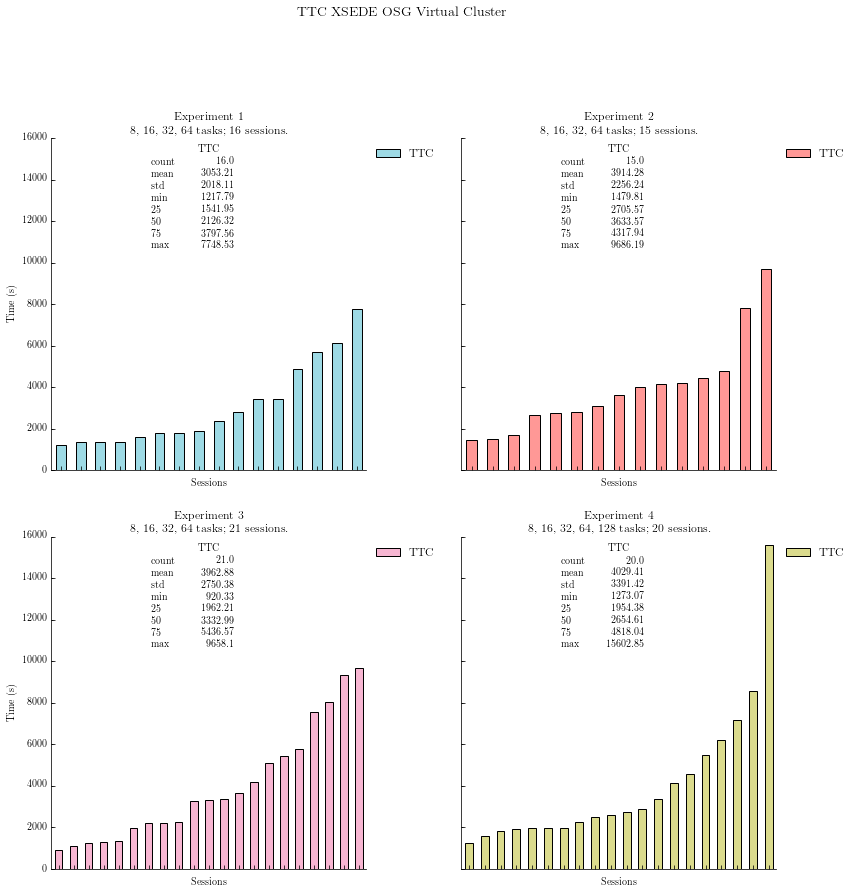

In [9]:
fig = plt.figure(figsize=(13,14))
fig.suptitle('TTC XSEDE OSG Virtual Cluster', fontsize=14)
plt.subplots_adjust(wspace=0.3, top=0.85)

ttc_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    ttc_subplots.append(sessions[ sessions['experiment'] == exp ].sort_values('TTC'))

colors = {'exp1': [tableau20[19]],
          'exp2': [tableau20[7] ],
          'exp3': [tableau20[13]],
          'exp4': [tableau20[17]],
          'exp5': [tableau20[15]]}


ax = []
for splt in range(4):
    session = ttc_subplots.pop(0)
    experiment = session['experiment'].unique()[0]
    ntasks = ', '.join([str(int(n)) for n in session['nunits'].unique()])
    color = colors[experiment]
    title = 'Experiment %s\n%s tasks; %s sessions.' % (experiment[3], ntasks, session.shape[0])

    if not ax:
        ax.append(fig.add_subplot(2, 2, splt+1))
    else:
        ax.append(fig.add_subplot(2, 2, splt+1, sharey=ax[0]))
    session['TTC'].plot(kind='bar', color=color, ax=ax[splt], title=title)
    ax[splt].spines["top"].set_visible(False)
    ax[splt].spines["right"].set_visible(False)
    ax[splt].get_xaxis().tick_bottom()
    ax[splt].get_yaxis().tick_left()
    ax[splt].set_xticklabels([])
    ax[splt].set_xlabel('Sessions')
    ax[splt].set_ylabel('Time (s)')
    ax[splt].legend(bbox_to_anchor=(1.25, 1))
    
    # Add table with statistical description of TTC values.
    table = pd.tools.plotting.table(ax[splt], 
                                    np.round(session['TTC'].describe(), 2),
                                    loc='upper center',
                                    colWidths=[0.2, 0.2, 0.2])
    
    # Eliminate the border of the table.
    for key, cell in table.get_celld().items():
        cell.set_linewidth(0)
    
    fig.add_subplot(ax[splt])
    
plt.savefig('figures/osg_ttc_experiments.pdf', dpi=600, bbox_inches='tight')

We see: 

* A large variation among the TTC of the runs of both experiments.
* Variations are similar between the two experiments. 

We still do not know: 

1. How the observed differences in TTC varies depending on the size of the workload.
2. What and how the entities of RADICAL-Pilot contribute to TTC and its variations.
3. What and how resource properties contribute to TTC and its variations. 

First, we subdivide each plot into four plots, one for each workload size: 8, 16, 32, 64 CUs.

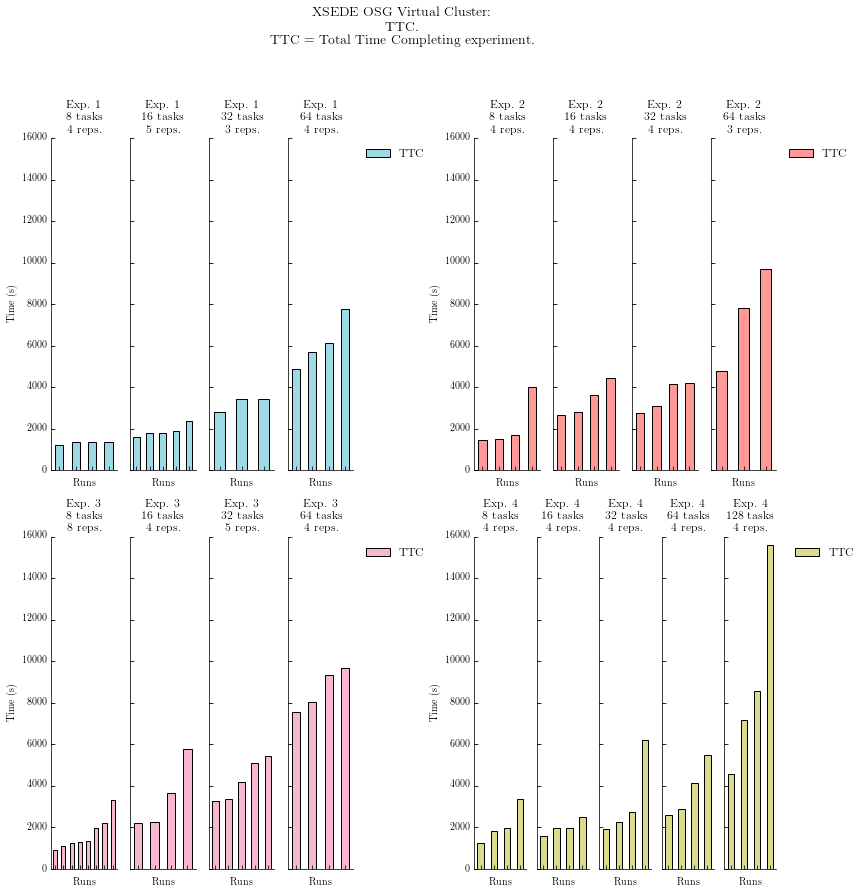

In [10]:
fig = plt.figure(figsize=(13,14))

title = 'XSEDE OSG Virtual Cluster'
subtitle = 'TTC'
defs = {'ttq': 'TTQ = Total Time Queuing pilots',
        'ttr': 'TTR = Total Time Running pilots',
        'ttc': 'TTC = Total Time Completing experiment'}

fig.suptitle('%s:\n%s.\n%s.' % (title, 
                                subtitle, 
                                defs['ttc']), fontsize=14)

gs = []
grid  = gridspec.GridSpec(2, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[2]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[3]))

ttc_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        if not sessions[ (sessions['experiment'] == exp) & 
                 (sessions['nunits'] == nun) ].empty:
            ttc_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                          (sessions['nunits'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[19]],
          'exp2': [tableau20[7] ],
          'exp3': [tableau20[13]],
          'exp4': [tableau20[17]],
          'exp5': [tableau20[15]]}

nun_exp = []
nun_exp.append(len(sessions[sessions['experiment'] == 'exp1']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp2']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp3']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp4']['nunits'].sort_values().unique()))

ax = []
i  = 0
while(i < len(ttc_subplots)):
    for gn in range(4):
        for gc in range(nun_exp[gn]):
            session = ttc_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Exp. %s\n%s tasks\n%s reps.' % (experiment[3], ntasks, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))

            session['TTC'].plot(kind='bar', ax=ax[i], color=color, title=title)

            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Runs')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7 or i == 16:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 7 or i == 3 or i == 11:
                ax[i].legend(labels=['TTC'], bbox_to_anchor=(2.25, 1))
            elif i == 16:
                ax[i].legend(labels=['TTC'], bbox_to_anchor=(2.70, 1))
#             else:
#                 ax[i].get_legend().set_visible(False)

            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttc_nunits.pdf', dpi=600, bbox_inches='tight')

The variations among TTC of workloads with the same number of CUs and between the two experiments are marked. Here we create a table with various measures of this variation for all the experiments and workload sizes.

In [11]:
ttc_stats = {}

for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        tag = exp+'_'+str(int(nun))
        ttc_stats[tag] = sessions[ (sessions['experiment'] == exp) & 
                                   (sessions['nunits'] == nun) ]['TTC'].describe()

ttc_compare = pd.DataFrame(ttc_stats)

sort_cols = ['exp1_8' , 'exp2_8' , 'exp1_16', 'exp2_16', 
             'exp1_32', 'exp2_32', 'exp1_64', 'exp2_64']
ttc_compare = ttc_compare.reindex_axis(sort_cols, axis=1)

ttc_compare

,exp1_8,exp2_8,exp1_16,exp2_16,exp1_32,exp2_32,exp1_64,exp2_64
count,4.000000,4.000000,5.000000,4.000000,3.000000,4.000000,4.000000,3.000000
mean,1329.148650,2169.554250,1889.015980,3385.244650,3215.066967,3550.343500,6111.126250,7431.210467
std,75.696194,1218.997636,292.162669,828.519558,362.381967,732.720257,1200.296161,2470.739147
min,1217.785800,1479.814100,1596.393500,2649.923700,2796.653500,2761.210100,4904.582800,4790.166400
25%,1313.580675,1511.927450,1793.549300,2770.503525,3108.323600,3009.557000,5486.647825,6303.719150
50%,1360.088800,1602.517150,1802.504700,3222.135900,3419.993700,3625.530900,5895.695900,7817.271900
75%,1375.656775,2260.143950,1874.733900,3836.877025,3424.273700,4166.317400,6520.174325,8751.732500
max,1378.631200,3993.368600,2377.898500,4446.783100,3428.553700,4189.102100,7748.530400,9686.193100


For 8 and 16 CUs, the TTC of the second experiment shows a mean twice as large as those of the first experiment. Less pronounced is the difference for mean of the TTC of 32 CUs. The mean of the TTC of the first experiment is 25% smaller that the one of the second experiment for 64 CUs.

The standard deviation among runs of the same experiment and number of CUs, varies between the two experiments. We describe this variation by calculating and comparing STD/mean for each experiment and workload size.

In [12]:
(ttc_compare.loc['std']/ttc_compare.loc['mean'])*100

exp1_8      5.695089
exp2_8     56.186548
exp1_16    15.466395
exp2_16    24.474437
exp1_32    11.271366
exp2_32    20.638010
exp1_64    19.641161
exp2_64    33.248138
dtype: float64

We notice that STD/mean among repetitions of the same run in Experiment 1 goes from 6.55% to 19.77%, increasing with the increase of the number of CUs. In Experiment 2, STD/mean goes from 20.63% up to 56.18%, independently from the amount of CUs executed by the repeated run. This shows:

* More measurements are needed to lower STD;
* TTC of experiment 2 may be influenced by one or more factors not present or relevant in Experiment 1.

In order to clarify this discrepancy between Experiments, we need to measure the components of TTC to understand what determines the differences in TTC within the same experiment and between the two. These measurements requires to:

* define the state model and transitions of the pilot and CU entities;
* verify that this model has been consistently implemented by each experimental run;
* define and measure the duration of each state and compare them across experimental runs.

## Pilot State Model

From the RADICAL-Pilot documentation and state model description, we know that:

<img src="images/global_state_model_rp_paper.png" width="600">

The states of the pilots are therefore as follow:
* pilot described, state **NEW**;
* pilot being queued in a pilot manager (PMGR), state **PMGR_LAUNCHING_PENDING**;
* pilot being queued in a local resource management system (LRMS), state **PMGR_LAUNCHING**;
* pilot having a bootstrapping agent, state **PMGR_ACTIVE_PENDING**;
* pilot having an active agent, state **PMGR_ACTIVE**;
* pilot marked as done by the PMGR, state **DONE**.

We verify whether our run match this model and we test whether the state model of each pilot of every session of all our experiments is the same. In this way we will know:

* whether our data are consistent with the authoritative RADICAL-Pilot state model; and
* what states of the pilots we can compare in our analysis given our dataset.

In [13]:
last_sv = None
last_id = None

for s in sessions['session']:
    sv = s.describe('state_values', etype=['pilot']).values()[0].values()[0]
   
    if last_sv and last_sv != sv:
        print "Different state models:\n%s = %s\n%s = %s" % (last_id, last_sv, sid, sv)

    last_sv = sv
    last_id = s._sid
        
pprint.pprint(last_sv)

{-1: None,
 0: 'NEW',
 1: 'PMGR_LAUNCHING_PENDING',
 2: 'PMGR_LAUNCHING',
 3: 'PMGR_ACTIVE_PENDING',
 4: 'PMGR_ACTIVE',
 5: ['CANCELED', 'FAILED', 'DONE']}


## Pilot State Durations

We define four durations to measure the aggreted time spent by all the pilots in each state:

| Duration           | Start timestamp        | End time Stamp         | Description | 
|--------------------|------------------------|------------------------|----------------|
| TT_PILOT_PMGR_SCHEDULING | NEW                    | PMGR_LAUNCHING_PENDING | total time spent by a pilot being scheduled to a PMGR | 
| TT_PILOT_PMGR_QUEUING    | PMGR_LAUNCHING_PENDING | PMGR_LAUNCHING         | total time spent by a pilot in a PMGR queue |
| TT_PILOT_LRMS_SUBMITTING | PMGR_LAUNCHING         | PMGR_ACTIVE_PENDING    | total time spent by a pilot being submitted to a LRMS |
| TT_PILOT_LRMS_QUEUING    | PMGR_ACTIVE_PENDING    | PMGR_ACTIVE            | total time spent by a pilot being queued in a LRMS queue |
| TT_PILOT_LRMS_RUNNING    | PMGR_ACTIVE            | DONE                   | total time spent by a pilot being active |

We should note that:
* Every state transition can end in state CANCELLED or FAILED, depending on the execution conditions. While this has no bearing on the semantics of the state model, when measuring durations we need to keep that in mind. This is why the API of session.duration() allows for passing **lists** of states as initial and end timestamp. 
* In presence of multiple pilots, the queue time of one or more pilot can overlap, partially overlap, or not overlap at all. When calculating the total amount of queue time for the whole run, we need to account for overlapping and, therefore, for time subtractions or additions. Luckily, the method `session.duration()` does all this for us.

Time to record some durations!

In [14]:
# Model of pilot durations.
ttpdm = {'TT_PILOT_PMGR_SCHEDULING': ['NEW'                   ,  'PMGR_LAUNCHING_PENDING'],
         'TT_PILOT_PMGR_QUEUING'   : ['PMGR_LAUNCHING_PENDING',  'PMGR_LAUNCHING'],
         'TT_PILOT_LRMS_SUBMITTING': ['PMGR_LAUNCHING'        ,  'PMGR_ACTIVE_PENDING'],
         'TT_PILOT_LRMS_QUEUING'   : ['PMGR_ACTIVE_PENDING'   ,  'PMGR_ACTIVE'],
         'TT_PILOT_LRMS_RUNNING'   : ['PMGR_ACTIVE'           , ['DONE',
                                                                 'CANCELED',
                                                                 'FAILED']]}

# Add total pilot durations to sessions' DF.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='pilot', inplace=False)
    for d in ttpdm.keys():
        sessions.ix[sid, d] = s.duration(ttpdm[d])

# Print the relevant portion of the 'session' DataFrame.
display(sessions[['TT_PILOT_PMGR_SCHEDULING', 'TT_PILOT_PMGR_QUEUING', 
                  'TT_PILOT_LRMS_SUBMITTING', 'TT_PILOT_LRMS_QUEUING', 
                  'TT_PILOT_LRMS_RUNNING']].head(3))
display(sessions[['TT_PILOT_PMGR_SCHEDULING', 'TT_PILOT_PMGR_QUEUING', 
                  'TT_PILOT_LRMS_SUBMITTING', 'TT_PILOT_LRMS_QUEUING', 
                  'TT_PILOT_LRMS_RUNNING']].tail(3))

,TT_PILOT_PMGR_SCHEDULING,TT_PILOT_PMGR_QUEUING,TT_PILOT_LRMS_SUBMITTING,TT_PILOT_LRMS_QUEUING,TT_PILOT_LRMS_RUNNING
rp.session.radical.mingtha.017033.0007,0.1115,0.0021,40.8441,448.9312,1331.9196
rp.session.radical.mingtha.017033.0008,0.1159,0.0019,32.6656,172.4000,4716.4960
rp.session.radical.mingtha.017033.0009,0.1041,0.0022,30.7743,235.8966,2603.0602


,TT_PILOT_PMGR_SCHEDULING,TT_PILOT_PMGR_QUEUING,TT_PILOT_LRMS_SUBMITTING,TT_PILOT_LRMS_QUEUING,TT_PILOT_LRMS_RUNNING
rp.session.radical.mturilli.017087.0004,0.0992,0.0031,34.9302,174.6902,2391.6327
rp.session.radical.mturilli.017087.0005,0.0966,0.0023,34.8597,201.2169,4397.9872
rp.session.radical.mturilli.017087.0006,0.0973,0.0015,34.5969,266.3615,1412.9129


## Total Time Queueing (TTQ)

We can now measure the first component of TTC: total queuing time (TTQ), i.e., the portion of TTC spent waiting for the pilots of each run to become active while they were queued in the OSG Connect broker. We choose TTQ because of the dominant role it plays on XSEDE and the need to compare that role with the one played within OSG.

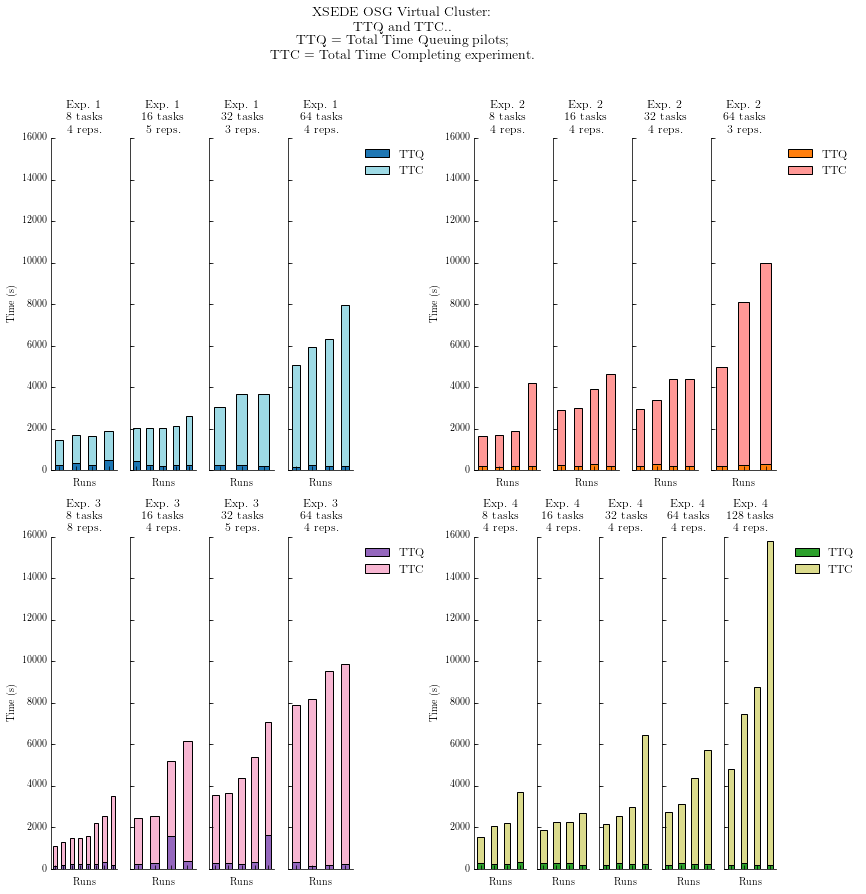

In [15]:
fig = plt.figure(figsize=(13,14))

title = 'XSEDE OSG Virtual Cluster'
subtitle = 'TTQ and TTC.'
defs = {'ttq': 'TTQ = Total Time Queuing pilots',
        'ttr': 'TTR = Total Time Running pilots',
        'ttc': 'TTC = Total Time Completing experiment'}

fig.suptitle('%s:\n%s.\n%s;\n%s.' % (title, 
                                     subtitle,
                                     defs['ttq'],
                                     defs['ttc']), fontsize=14)

gs = []
grid  = gridspec.GridSpec(2, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[2]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[3]))

ttc_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        if not sessions[ (sessions['experiment'] == exp) & 
                 (sessions['nunits'] == nun) ].empty:
            ttc_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                          (sessions['nunits'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[0] ,tableau20[19]],
          'exp2': [tableau20[2] ,tableau20[7] ],
          'exp3': [tableau20[8] ,tableau20[13]],
          'exp4': [tableau20[4] ,tableau20[17]],
          'exp5': [tableau20[10],tableau20[15]]}


nun_exp = []
nun_exp.append(len(sessions[sessions['experiment'] == 'exp1']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp2']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp3']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp4']['nunits'].sort_values().unique()))

ax = []
i  = 0
while(i < len(ttc_subplots)):
    for gn in range(4):
        for gc in range(nun_exp[gn]):
            session = ttc_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Exp. %s\n%s tasks\n%s reps.' % (experiment[3], ntasks, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))

            session[['TT_PILOT_LRMS_QUEUING', 
                     'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)

            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Runs')

            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7 or i == 16:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 7 or i == 3 or i == 11:
                ax[i].legend(labels=['TTQ','TTC'], bbox_to_anchor=(2.25, 1))
            elif i == 16:
                ax[i].legend(labels=['TTQ','TTC'], bbox_to_anchor=(2.70, 1))
            else:
                ax[i].get_legend().set_visible(False)
            
            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttq_ttc_nunits.pdf', dpi=600, bbox_inches='tight')

Across runs and experiments, TTQ is:

* relatively consistent.
* a small part of TTC.

In [16]:
ttc_stats = {}

for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        tag = exp+'_'+str(int(nun))
        ttc_stats[tag] = sessions[ (sessions['experiment'] == exp) & 
                                   (sessions['nunits'] == nun) ]['TT_PILOT_LRMS_QUEUING'].describe()

ttc_compare = pd.DataFrame(ttc_stats)

sort_cols = ['exp1_8' , 'exp2_8' , 'exp1_16', 'exp2_16', 
             'exp1_32', 'exp2_32', 'exp1_64', 'exp2_64']
ttc_compare = ttc_compare.reindex_axis(sort_cols, axis=1)

ttc_compare.round(2)

,exp1_8,exp2_8,exp1_16,exp2_16,exp1_32,exp2_32,exp1_64,exp2_64
count,4.00,4.00,5.00,4.00,3.00,4.00,4.00,3.00
mean,345.70,195.96,285.81,237.65,241.09,228.17,217.87,252.16
std,118.48,22.91,92.50,48.81,14.39,46.35,31.70,47.25
min,260.74,177.78,229.38,188.40,230.01,193.47,172.40,197.89
25%,267.61,182.89,233.92,202.18,232.95,200.77,210.09,236.15
50%,302.94,188.47,247.59,233.88,235.90,211.78,226.96,274.40
75%,381.03,201.54,269.21,269.34,246.62,239.18,234.73,279.29
max,516.15,229.15,448.93,294.44,257.35,295.66,245.16,284.18


Even with an average of just 4 runs for each workload size, TTQ variance is relatively small with a couple of exceptions, as shown by STD/mean 

In [17]:
std_mean = (ttc_compare.loc['std']/ttc_compare.loc['mean'])*100
std_mean.round(2)

exp1_8     34.27
exp2_8     11.69
exp1_16    32.36
exp2_16    20.54
exp1_32     5.97
exp2_32    20.31
exp1_64    14.55
exp2_64    18.74
dtype: float64

As with TTC, more experiments and runs are needed. Importantly, due to the dynamic variables of OSG behavior (e.g., number, type or resources available to the broker at any given point in time), it would be useful to perform the runs sequentially so to collect the data (relatively) independent from these dynamics; or characterize these dynamics with long term measurements taken at discrete intervals. 

## Queue Time (Tq)

Every run uses four 1-core pilots, submitted to the OSG broker. We can look at the frequency of each pilot Tq (i.e., not TTQ but the queuing time of each pilot) without distinguishing among workload sizes and between experiments. We create a new DataFrame `pilot` containing all the durations of each pilot, not sessions. 

| Duration        | Start timestamp        | End time Stamp         | Description | 
|-----------------|------------------------|------------------------|-------------|
| PMGR_SCHEDULING | NEW                    | PMGR_LAUNCHING_PENDING | Time spent by a pilot being scheduled to a PMGR | 
| PMGR_QUEUING    | PMGR_LAUNCHING_PENDING | PMGR_LAUNCHING         | Time spent by a pilot in a PMGR queue |
| LRMS_SUBMITTING | PMGR_LAUNCHING         | PMGR_ACTIVE_PENDING    | Time spent by a pilot being submitted to a LRMS |
| LRMS_QUEUING    | PMGR_ACTIVE_PENDING    | PMGR_ACTIVE            | Time spent by a pilot being queued in a LRMS queue |
| LRMS_RUNNING    | PMGR_ACTIVE            | DONE                   | Time spent by a pilot being active |

Note how only the name of the duration changes when comparing this table to the table with the durations for a session. The pilot state model is always the same, here it is used to calculate durations for a specific entity; for a session is used to calculate the aggregated duration for all the entities of a type in that session.

In [18]:
# Model of pilot durations.
pdm = {'PMGR_SCHEDULING': ['NEW'                   ,  'PMGR_LAUNCHING_PENDING'],
       'PMGR_QUEUING'   : ['PMGR_LAUNCHING_PENDING',  'PMGR_LAUNCHING'],
       'LRMS_SUBMITTING': ['PMGR_LAUNCHING'        ,  'PMGR_ACTIVE_PENDING'],
       'LRMS_QUEUING'   : ['PMGR_ACTIVE_PENDING'   ,  'PMGR_ACTIVE'],
       'LRMS_RUNNING'   : ['PMGR_ACTIVE'           , ['DONE',
                                                      'CANCELED',
                                                      'FAILED']]}

# DataFrame structure for pilot durations. 
pds = { 'pid': [],
        'sid': [],
        'experiment'     : [],
        'PMGR_SCHEDULING': [],
        'PMGR_QUEUING'   : [],
        'LRMS_SUBMITTING': [],
        'LRMS_QUEUING'   : [],
        'LRMS_RUNNING'   : []}

# Calculate the duration for each state of each 
# pilot of each run and Populate the DataFrame 
# structure.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='pilot', inplace=False)
    for p in s.list('uid'):
        sf = s.filter(uid=p, inplace=False)
        pds['pid'].append(p)
        pds['sid'].append(sid)
        pds['experiment'].append(sessions.ix[sid, 'experiment'])
        for d in pdm.keys():
            if (not sf.timestamps(state=pdm[d][0]) or 
                not sf.timestamps(state=pdm[d][1])):
                pds[d].append(None)
                continue
            pds[d].append(sf.duration(pdm[d]))

# Populate the DataFrame.
pilots = pd.DataFrame(pds)

display(pilots.head(3))
display(pilots.tail(3))

,LRMS_QUEUING,LRMS_RUNNING,LRMS_SUBMITTING,PMGR_QUEUING,PMGR_SCHEDULING,experiment,pid,sid
0,217.1893,1330.8070,40.8441,0.0021,0.1115,exp1,pilot.0002,rp.session.radical.mingtha.017033.0007
1,220.5954,1321.0085,40.8441,0.0021,0.1115,exp1,pilot.0003,rp.session.radical.mingtha.017033.0007
2,448.9312,1096.9671,40.8441,0.0021,0.1115,exp1,pilot.0000,rp.session.radical.mingtha.017033.0007


,LRMS_QUEUING,LRMS_RUNNING,LRMS_SUBMITTING,PMGR_QUEUING,PMGR_SCHEDULING,experiment,pid,sid
365,154.5414,1400.0966,34.5969,0.0015,0.0973,exp4,pilot.0007,rp.session.radical.mturilli.017087.0006
366,155.1169,1399.5211,34.5969,0.0015,0.0973,exp4,pilot.0004,rp.session.radical.mturilli.017087.0006
367,141.7251,1412.9129,34.5969,0.0015,0.0973,exp4,pilot.0005,rp.session.radical.mturilli.017087.0006


We calculate add the name of the resource (hostID) on which the pilot (agent) have become active to the pilots DataFrame. Often, the hostID recoreded by RADICAL-Pilot is not the public name of the resource on whic the pilot becomes active but, instead, the name of a working/compute node/unit of that resource. We use an heuristic to isolate the portion of the hostID string that is common to all the nodes/units of the same resource. It should be noted though, that in some cases this is not possible.

In [19]:
def parse_osg_hostid(hostid):
    '''
    Heuristic: eliminate node-specific information from hostID.
    '''
    domain = None
    
    # Split domain name from IP.
    host = hostid.split(':')

    # Split domain name into words.
    words = host[0].split('.')

    # Get the words in the domain name that do not contain 
    # numbers. Most hostnames have no number but there are 
    # exceptions.
    literals = [l for l in words if not any((number in set('0123456789')) for number in l)]            

    # Check for exceptions: 
    # a. every word of the domain name has a number
    if len(literals) == 0:

        # Some hostname use '-' instead of '.' as word separator.
        # The parser would have returned a single word and the 
        # any of that word may have a number.
        if '-' in host[0]:
            words = host[0].split('-')
            literals = [l for l in words if not any((number in set('0123456789')) for number in l)]

            # FIXME: We do not check the size of literals. 
            domain = '.'.join(literals)

        # Some hostnames may have only the name of the node. We
        # have to keep the IP to decide later on whether two nodes
        # are likely to belong to the same cluster.
        elif 'n' in host[0] or 'nod' in host[0]:
            domain = '.'.join(host)

        # The hostname is identified by an alphanumeric string
        else:
            domain = '.'.join(host)

    # Some hostnames DO have numbers in their name.
    elif len(literals) == 1:
        domain = '.'.join(words[1:])

    # Some hostname are just simple to parse.
    else:
        domain = '.'.join(literals)

    return domain

We use this heuristic with the pilots DataFrame to which we add two columns: 'hostID' and 'parsed_hostID'.

In [20]:
for pix in pilots.index:
    sid = pilots.ix[pix,'sid']
    pid = pilots.ix[pix,'pid']
    pls = sessions.ix[sid, 'session'].filter(uid=pid, inplace=False).get(etype=['pilot'])
    if len(pls) != 1:
        print "Error: session filter on uid returned multiple pilots"
        break
    hostid = pls[0].cfg['hostid']
    if hostid:
        domain = parse_osg_hostid(hostid)
    else:
        domain = np.nan
    pilots.ix[pix,'hostID'] = hostid
    pilots.ix[pix,'parsed_hostID'] = domain

We plot the frequency of Tq for both experiments as histogram. Ideally, this should be the first step towards the definition of the characteristic distribution of Tq. Part of this characterization will be to study how stable this distribution is across time, i.e., between two experiments executed at different point in time. As we know that the pool or resources of OSG Is both heterogeneous and dynamic, we expect this distribution not to be stable across time due to the potentially different pool of resources available at any point in time.

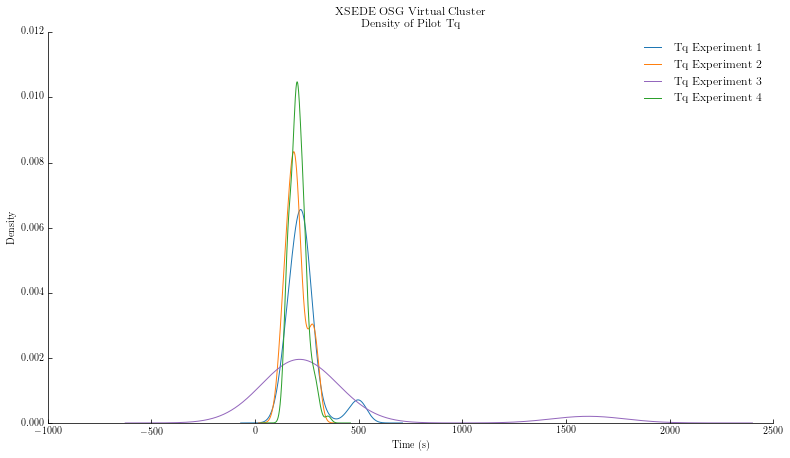

In [21]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Pilot Tq'

tq_exp1 = pilots[pilots['experiment'].str.contains('exp1')]['LRMS_QUEUING'].dropna().reset_index(drop=True)
tq_exp2 = pilots[pilots['experiment'].str.contains('exp2')]['LRMS_QUEUING'].dropna().reset_index(drop=True)
tq_exp3 = pilots[pilots['experiment'].str.contains('exp3')]['LRMS_QUEUING'].dropna().reset_index(drop=True)
tq_exp4 = pilots[pilots['experiment'].str.contains('exp4')]['LRMS_QUEUING'].dropna().reset_index(drop=True)

plots = pd.DataFrame({'exp1': tq_exp1, 'exp2': tq_exp2,  'exp3': tq_exp3, 'exp4': tq_exp4}) 

#plots.plot.hist(ax=ax, color=[tableau20[19],tableau20[7],tableau20[13],tableau20[17]], title=title)
plots.plot.density(ax=ax, color=[tableau20[0],tableau20[2],tableau20[8],tableau20[4]], title=title)

ax.set_xlabel('Time (s)')
ax.legend(labels=['Tq Experiment 1','Tq Experiment 2','Tq Experiment 3','Tq Experiment 4'])

plt.savefig('figures/osg_tq_frequency.pdf', dpi=600, bbox_inches='tight')

The diagrams hint to bimodal distributions, more measurements are required to study this further.

## Total Time Running (TTR)

We know that TTQ marginally contributes to the TTC of each run. We still do not know whether most of TTC depends on the running time of the pilots or on the overheads of bootstrapping and managing them. We suspect the former but we have to exclude the latter. 

We define TTR as the aggregated time spent by the pilots in running state. We plot TTR stacked with TTQ and TTC and we verify whether TTR and the remaining part of TTC are analogous. As usual, this could be done just numerically but, hey, we spent a senseless ton of time dooming matplotlib so now we want to use it!  

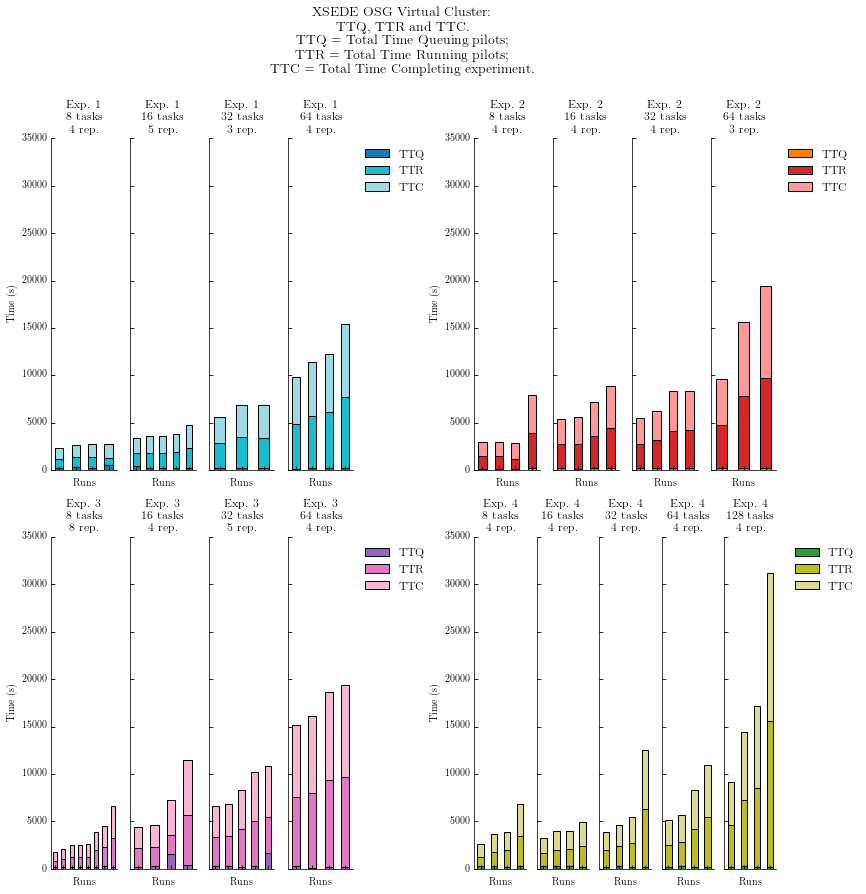

In [22]:
fig = plt.figure(figsize=(13,14))

title = 'XSEDE OSG Virtual Cluster'
subtitle = 'TTQ, TTR and TTC'
defs = {'ttq': 'TTQ = Total Time Queuing pilots',
        'ttr': 'TTR = Total Time Running pilots',
        'ttc': 'TTC = Total Time Completing experiment'}

fig.suptitle('%s:\n%s.\n%s;\n%s;\n%s.' % (title, 
                                      subtitle, 
                                      defs['ttq'], 
                                      defs['ttr'], 
                                      defs['ttc']), fontsize=14)

gs = []
grid  = gridspec.GridSpec(2, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[2]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[3]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        if not sessions[ (sessions['experiment'] == exp) & 
                 (sessions['nunits'] == nun) ].empty:
            ttq_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                          (sessions['nunits'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[0] ,tableau20[18],tableau20[19]],
          'exp2': [tableau20[2] ,tableau20[6] ,tableau20[7] ],
          'exp3': [tableau20[8] ,tableau20[12],tableau20[13]],
          'exp4': [tableau20[4] ,tableau20[16],tableau20[17]],
          'exp5': [tableau20[10],tableau20[14],tableau20[15]]}

nun_exp = []
nun_exp.append(len(sessions[sessions['experiment'] == 'exp1']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp2']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp3']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp4']['nunits'].sort_values().unique()))

ax = []
i  = 0
while(i < len(ttq_subplots)):
    for gn in range(4):
        for gc in range(nun_exp[gn]):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Exp. %s\n%s tasks\n%s rep.' % (experiment[3], ntasks, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))

            session[['TT_PILOT_LRMS_QUEUING', 
                     'TT_PILOT_LRMS_RUNNING',
                     'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Runs')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7 or i == 16:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 7 or i == 3 or i == 11:
                ax[i].legend(labels=['TTQ','TTR','TTC'], bbox_to_anchor=(2.25, 1))
            elif i == 16:
                ax[i].legend(labels=['TTQ','TTR','TTC'], bbox_to_anchor=(2.70, 1))
            else:
                ax[i].get_legend().set_visible(False)
            
            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttq_ttr_ttc_nunits.pdf', dpi=600, bbox_inches='tight')

As expected, TTR is largely equivalent to TTC-TTQ. This tells us that we will have to investigate the time spent describing, binding, scheduling, and executing CUs, measuring whether pilots TTR is spent effectively running CUs or managing them. Also, we will have to measure how much time is spent staging data in and out to and from the resources. In these experiments, data staging was not performed so we will limit our analysis to the execution time of CUs. 

In the diagram above, we confirm that the differences previously observed between the TTC of Experiment 1 and 2 (particularly evident when comparing runs with 8 and 64 units). As they depend on running pilots, we investigate whether every run uses the same amount of (active) pilots to execute CUs. The rationale is that when using fewer pilots, running the same amount of CUs will take more time (sequential execution on a single core).

We add a column to the `session` DataFrame with the number of pilots for each session.

In [23]:
# Temporary: workaround for bug ticket \#15. Calculates 
# the number of active pilots by looking into the 
# length of the list returned by timestamp on the 
# PMGR_ACTIVE state.

for sid in sessions.index:
    sessions.ix[sid, 'npilot_active'] = len(sessions.ix[sid, 'session'].filter(etype='pilot', inplace=False).timestamps(state='PMGR_ACTIVE'))

display(sessions[['npilot_active']].head(3))
display(sessions[['npilot_active']].tail(3))

,npilot_active
rp.session.radical.mingtha.017033.0007,4.0
rp.session.radical.mingtha.017033.0008,4.0
rp.session.radical.mingtha.017033.0009,4.0


,npilot_active
rp.session.radical.mturilli.017087.0004,8.0
rp.session.radical.mturilli.017087.0005,8.0
rp.session.radical.mturilli.017087.0006,8.0


We add the numbers of pilot that become active in each run to the plot we used above to show TTQ, TTR, and TTC.

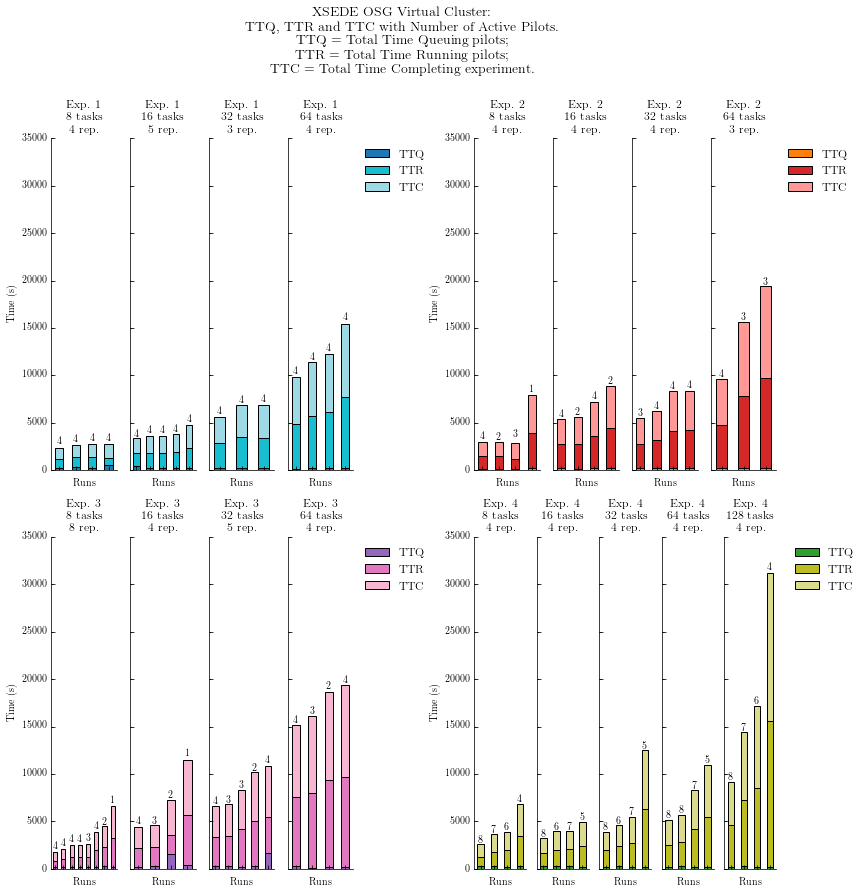

In [24]:
fig = plt.figure(figsize=(13,14))

title = 'XSEDE OSG Virtual Cluster'
subtitle = 'TTQ, TTR and TTC with Number of Active Pilots'
defs = {'ttq': 'TTQ = Total Time Queuing pilots',
        'ttr': 'TTR = Total Time Running pilots',
        'ttc': 'TTC = Total Time Completing experiment'}

fig.suptitle('%s:\n%s.\n%s;\n%s;\n%s.' % (title, 
                                      subtitle, 
                                      defs['ttq'], 
                                      defs['ttr'], 
                                      defs['ttc']), fontsize=14)

gs = []
grid  = gridspec.GridSpec(2, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[2]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[3]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        if not sessions[ (sessions['experiment'] == exp) & 
                 (sessions['nunits'] == nun) ].empty:
            ttq_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                          (sessions['nunits'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[0] ,tableau20[18],tableau20[19]],
          'exp2': [tableau20[2] ,tableau20[6] ,tableau20[7] ],
          'exp3': [tableau20[8] ,tableau20[12],tableau20[13]],
          'exp4': [tableau20[4] ,tableau20[16],tableau20[17]],
          'exp5': [tableau20[10],tableau20[14],tableau20[15]]}

nun_exp = []
nun_exp.append(len(sessions[sessions['experiment'] == 'exp1']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp2']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp3']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp4']['nunits'].sort_values().unique()))

ax = []
i  = 0
while(i < len(ttq_subplots)):
    for gn in range(4):
        for gc in range(nun_exp[gn]):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Exp. %s\n%s tasks\n%s rep.' % (experiment[3], ntasks, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['TT_PILOT_LRMS_QUEUING', 
                     'TT_PILOT_LRMS_RUNNING',
                     'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Runs')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7 or i == 16:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 7 or i == 3 or i == 11:
                ax[i].legend(labels=['TTQ','TTR','TTC'], bbox_to_anchor=(2.25, 1))
            elif i == 16:
                ax[i].legend(labels=['TTQ','TTR','TTC'], bbox_to_anchor=(2.70, 1))
            else:
                ax[i].get_legend().set_visible(False)
                
            # Add labels with number of pilots per session.
            rects = ax[i].patches
            labels = [int(l) for l in session['npilot_active']]
            for rect, label in zip(rects[-repetitions:], labels):
                height = rect.get_height()
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           (height*2), label, ha='center', 
                           va='bottom')

            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttq_ttr_ttc_npactive_nunits.pdf', dpi=600, bbox_inches='tight')

As expected, the largest differences we observed in TTC and TTR among the runs with the same number of CU and among experiments map to the number of pilots used to execute CUs. Our analysis show that the two experiments have a different number of independent variables. Any comparison has to take into account whether the measure observed depends on the number of active pilots used to execute CUs. 

We have now exhausted the analyses of TTC via the defined pilot durations. We have now to look at the composition of TTR, namely at the durations depending on the CU states.

## Compute Unit State Model Interpretation

From the RADICAL-Pilot documentation and state model description, we know that:

<img src="images/global_state_model_rp_paper.png" width="600">

The states of the units are therefore as follow:
* unit described, state **NEW**;
* unit queuing in a unit manager (UMGR)'s queue, state **UMGR_SCHEDULING_PENDING**;
* unit being scheduled by a UMGR to an active pilot agent, state **UMGR_SCHEDULING**;
* input file(s) of a scheduling unit queuing in a UMGR's queue, state **UMGR_STAGING_INPUT_PENDING**;
* input file(s) of a scheduling unit being staged to a (pilot) agent's MongoDB queue. The agent is the same on which the input file(s)' unit is being scheduled, state **UMGR_STAGING_INPUT**;
* input file(s) of a scheduling unit queuing in the (pilot) agent's MongoDB queue. The agent is the same on which the input file(s)' unit is being scheduled, state **AGENT_STAGING_INPUT_PENDING**;
* input file(s) of a scheduling unit being staged to an agent's resource. The agent is the same on which the input file(s)' unit is being scheduled, state **AGENT_STAGING_INPUT**; 
* unit queuing in a agent's queue, state **AGENT_SCHEDULING_PENDING**;
* unit being scheduled by the agent for execution on pilot's resources, state **AGENT_SCHEDULING**;
* unit queuing in a agent's queue, state **AGENT_EXECUTING_PENDING**;
* unit being executed by the agent on pilot's resources, state **AGENT_EXECUTING**;
* output file(s) of an executed unit queuing on an agent's queue, state **AGENT_STAGING_OUTPUT_PENDING**;
* output file(s) of an executed unit being staged on a UMGR's MongoDB queue, state **AGENT_STAGING_OUTPUT**;
* output file(s) of an executed unit queuing on a UMGR's MongoDB queue, state **UMGR_STAGING_OUTPUT_PENDING**;
* output file(s) of an executed unit being staged on a UMGR's resource (e.g., user's workstation), state **UMGR_STAGING_OUTPUT**;
* unit marked as done by a UMGR, state **DONE**.

As done with the pilot state model, we verify whether our run match the compute unit state model, and we test whether the state model of each unit of every session of all experiments is the same. In this way we will know:

* whether our data are consistent with the authoritative RADICAL-Pilot state model; and
* what states of the units we can compare in our analysis given our datasets.

In [25]:
last_sv = None
last_id = None

for s in sessions['session']:
    sv = s.describe('state_values', etype=['unit']).values()[0].values()[0]
   
    if last_sv and last_sv != sv:
        print "Different state models:\n%s = %s\n%s = %s" % (last_id, last_sv, sid, sv)

    last_sv = sv
    last_id = s._sid
        
pprint.pprint(last_sv)

{-1: None,
 0: 'NEW',
 1: 'UMGR_SCHEDULING_PENDING',
 2: 'UMGR_SCHEDULING',
 3: 'UMGR_STAGING_INPUT_PENDING',
 4: 'UMGR_STAGING_INPUT',
 5: 'AGENT_STAGING_INPUT_PENDING',
 6: 'AGENT_STAGING_INPUT',
 7: 'AGENT_SCHEDULING_PENDING',
 8: 'AGENT_SCHEDULING',
 9: 'AGENT_EXECUTING_PENDING',
 10: 'AGENT_EXECUTING',
 11: 'AGENT_STAGING_OUTPUT_PENDING',
 12: 'AGENT_STAGING_OUTPUT',
 13: 'UMGR_STAGING_OUTPUT_PENDING',
 14: 'UMGR_STAGING_OUTPUT',
 15: ['CANCELED', 'DONE', 'FAILED']}


## Unit Durations

We define 15 durations to measure the aggreted time spent by all the units of a session in each state:

| Duration                           | Start timestamp              | End time Stamp               | Description |
|------------------------------------|------------------------------|------------------------------|-------------|
| TT_UNIT_UMGR_SCHEDULING            | NEW                          | UMGR_SCHEDULING_PENDING      | total time spent by a unit being scheduled to a UMGR | 
| TT_UNIT_UMGR_BINDING               | UMGR_SCHEDULING_PENDING      | UMGR_SCHEDULING              | total time spent by a unit being bound to a pilot by a UMGR | 
| TT_IF_UMGR_SCHEDULING              | UMGR_SCHEDULING              | UMGR_STAGING_INPUT_PENDING   | total time spent by input file(s) being scheduled to a UMGR | 
| TT_IF_UMGR_QUEING                  | UMGR_STAGING_INPUT_PENDING   | UMGR_STAGING_INPUT           | total time spent by input file(s) queuing in a UMGR | 
| TT_IF_AGENT_SCHEDULING             | UMGR_STAGING_INPUT           | AGENT_STAGING_INPUT_PENDING  | total time spent by input file(s) being scheduled to an agent's MongoDB queue |
| TT_IF_AGENT_QUEUING                | AGENT_STAGING_INPUT_PENDING  | AGENT_STAGING_INPUT          | total time spent by input file(s) queuing in an agent's MongoDB queue |
| TT_IF_AGENT_TRANSFERRING           | AGENT_STAGING_INPUT          | AGENT_SCHEDULING_PENDING     | total time spent by input file(s)' payload to be transferred from where the UMGR is being executed (e.g., the user's workstation) to the resource on which the agent is executing |
| TT_UNIT_AGENT_QUEUING              | AGENT_SCHEDULING_PENDING     | AGENT_SCHEDULING             | total time spent by a unit in the agent's scheduling queue | 
| TT_UNIT_AGENT_SCHEDULING           | AGENT_SCHEDULING             | AGENT_EXECUTING_PENDING      | total time spent by a unit to be scheduled to the agent's executing queue | 
| TT_UNIT_AGENT_QUEUING_EXECUTION    | AGENT_EXECUTING_PENDING      | AGENT_EXECUTING              | total time spent by a unit in the agent's executing queue  |
| TT_UNIT_AGENT_EXECUTING            | AGENT_EXECUTING              | AGENT_STAGING_OUTPUT_PENDING | total time spent by a unit executing |
| TT_OF_AGENT_QUEUING                | AGENT_STAGING_OUTPUT_PENDING | AGENT_STAGING_OUTPUT         | total time spent by output file(s) queuing in the agent's stage out queue |
| TT_OF_UMGR_SCHEDULING              | AGENT_STAGING_OUTPUT         | UMGR_STAGING_OUTPUT_PENDING  | total time spent by output file(s) being scheduled to a UMGR's MongoDB queue |
| TT_OF_UMGR_QUEUING                 | UMGR_STAGING_OUTPUT_PENDING  | UMGR_STAGING_OUTPUT          | total time spent by output file(s) queuing in a UMGR's MongoDB queue |
| TT_OF_UMGR_TRANSFERRING            | UMGR_STAGING_OUTPUT          | DONE                         | total time spent by output file(s)' payload to be transferred from the resource to where the UMGR is being executed (e.g., the user's workstation) |

## Unit Durations Aggregates

Durations can be aggregated so to represent a middle-level semantics:

```
* TT_UNIT_RP_OVERHEAD    = TT_UMGR_UNIT_SCHEDULING         + 
                           TT_AGENT_UNIT_QUEUING           + 
                           TT_AGENT_UNIT_SCHEDULING        + 
                           TT_AGENT_UNIT_QUEUING_EXECUTION
                          
* TT_IF_RP_OVERHEAD      = TT_UMGR_IF_SCHEDULING           +
                           TT_UMGR_IF_QUEING               +
                           TT_AGENT_IF_QUEUING

* TT_OF_RP_OVERHEAD      = TT_AGENT_OF_QUEUING             +
                           TT_UMGR_OF_QUEING               +

* TT_IF_NETWORK_OVERHEAD = TT_AGENT_IF_SCHEDULING          +
                           TT_AGENT_IF_TRANSFERRING

* TT_OF_NETWORK_OVERHEAD = TT_UMGR_OF_SCHEDULING           +
                           TT_UMGR_OF_TRANSFERRING

* TT_IF_STAGING          = TT_IF_RP_OVERHEAD               +
                           TT_IF_NETWORK_OVERHEAD

* TT_OF_STAGING          = TT_OF_RP_OVERHEAD               +
                           TT_OF_NETWORK_OVERHEAD
```
and higher-level semantics:
```
* TT_RP_OVERHEADS        = TT_UNIT_RP_OVERHEAD             + 
                           TT_IF_RP_OVERHEAD               + 
                           TT_OF_RP_OVERHEAD

* TT_NETWORK_OVERHEADS   = TT_IF_NETWORK_OVERHEAD          +
                           TT_OF_NETWORK_OVERHEAD

* TT_FILE_STAGING        = TT_IF_STAGING                   + 
                           TT_OF_STAGING

* TT_UNIT_EXECUTING      = TT_AGENT_UNIT_EXECUTING
```

## Consistency Rules

Note that we can derive consistency constraints from these models. For every session, the following has always to be true:


As done with the pilot, we first calculate the overall time spent during the session to execute CUs.

In [26]:
# Model of unit durations.
udm = {'TT_UNIT_UMGR_SCHEDULING'   : ['NEW'                         , 'UMGR_SCHEDULING_PENDING'],
       'TT_UNIT_UMGR_BINDING'      : ['UMGR_SCHEDULING_PENDING'     , 'UMGR_SCHEDULING'],
       'TT_IF_UMGR_SCHEDULING'     : ['UMGR_SCHEDULING'             , 'UMGR_STAGING_INPUT_PENDING'], 
       'TT_IF_UMGR_QUEING'         : ['UMGR_STAGING_INPUT_PENDING'  , 'UMGR_STAGING_INPUT'],
       'TT_IF_AGENT_SCHEDULING'    : ['UMGR_STAGING_INPUT'          , 'AGENT_STAGING_INPUT_PENDING'],  
       'TT_IF_AGENT_QUEUING'       : ['AGENT_STAGING_INPUT_PENDING' , 'AGENT_STAGING_INPUT'], 
       'TT_IF_AGENT_TRANSFERRING'  : ['AGENT_STAGING_INPUT'         , 'AGENT_SCHEDULING_PENDING'],
       'TT_UNIT_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING'    , 'AGENT_SCHEDULING'],
       'TT_UNIT_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING'            , 'AGENT_EXECUTING_PENDING'], 
       'TT_UNIT_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING'     , 'AGENT_EXECUTING'], 
       'TT_UNIT_AGENT_EXECUTING'   : ['AGENT_EXECUTING'             , 'AGENT_STAGING_OUTPUT_PENDING'], 
       'TT_OF_AGENT_QUEUING'       : ['AGENT_STAGING_OUTPUT_PENDING', 'AGENT_STAGING_OUTPUT'], 
       'TT_OF_UMGR_SCHEDULING'     : ['AGENT_STAGING_OUTPUT'        , 'UMGR_STAGING_OUTPUT_PENDING'],
       'TT_OF_UMGR_QUEUING'        : ['UMGR_STAGING_OUTPUT_PENDING' , 'UMGR_STAGING_OUTPUT'],
       'TT_OF_UMGR_TRANSFERRING'   : ['UMGR_STAGING_OUTPUT'         , 'DONE']}

# Calculate total unit durations for each session.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='unit', inplace=False)
    for d in udm.keys():
        sessions.ix[sid, d] = s.duration(udm[d])

# Print the new columns of the session DF with total unit durations.
display(sessions[['TT_UNIT_UMGR_SCHEDULING'   , 'TT_UNIT_UMGR_BINDING'   , 'TT_IF_UMGR_SCHEDULING'   , 
                  'TT_IF_UMGR_QUEING'         , 'TT_IF_AGENT_SCHEDULING' , 'TT_IF_AGENT_QUEUING'     , 
                  'TT_IF_AGENT_TRANSFERRING'  , 'TT_UNIT_AGENT_QUEUING'  , 'TT_UNIT_AGENT_SCHEDULING', 
                  'TT_UNIT_AGENT_QUEUING_EXEC', 'TT_UNIT_AGENT_EXECUTING', 'TT_OF_AGENT_QUEUING'     , 
                  'TT_OF_UMGR_SCHEDULING'     , 'TT_OF_UMGR_QUEUING'     , 'TT_OF_UMGR_TRANSFERRING']].head(3))
display(sessions[['TT_UNIT_UMGR_SCHEDULING'   , 'TT_UNIT_UMGR_BINDING'   , 'TT_IF_UMGR_SCHEDULING'   , 
                  'TT_IF_UMGR_QUEING'         , 'TT_IF_AGENT_SCHEDULING' , 'TT_IF_AGENT_QUEUING'     , 
                  'TT_IF_AGENT_TRANSFERRING'  , 'TT_UNIT_AGENT_QUEUING'  , 'TT_UNIT_AGENT_SCHEDULING', 
                  'TT_UNIT_AGENT_QUEUING_EXEC', 'TT_UNIT_AGENT_EXECUTING', 'TT_OF_AGENT_QUEUING'     , 
                  'TT_OF_UMGR_SCHEDULING'     , 'TT_OF_UMGR_QUEUING'     , 'TT_OF_UMGR_TRANSFERRING']].tail(3))

,TT_UNIT_UMGR_SCHEDULING,TT_UNIT_UMGR_BINDING,TT_IF_UMGR_SCHEDULING,TT_IF_UMGR_QUEING,TT_IF_AGENT_SCHEDULING,TT_IF_AGENT_QUEUING,TT_IF_AGENT_TRANSFERRING,TT_UNIT_AGENT_QUEUING,TT_UNIT_AGENT_SCHEDULING,TT_UNIT_AGENT_QUEUING_EXEC,TT_UNIT_AGENT_EXECUTING,TT_OF_AGENT_QUEUING,TT_OF_UMGR_SCHEDULING,TT_OF_UMGR_QUEUING,TT_OF_UMGR_TRANSFERRING
rp.session.radical.mingtha.017033.0007,0.2603,0.0073,893.4051,0.014800,0.003800,73.470300,0.004801,0.018100,953.1781,0.0223,1295.3383,1.4884,0.0124,36.893699,0.004000
rp.session.radical.mingtha.017033.0008,0.4086,0.0375,4049.1254,0.069201,0.017399,410.061300,0.018901,0.089498,4281.2538,0.0920,4684.3459,0.0937,0.0410,151.972700,0.017699
rp.session.radical.mingtha.017033.0009,0.9616,0.0105,2038.6201,0.032899,0.008401,149.587099,0.009701,0.040300,2212.5801,0.0445,2576.7140,1.3749,0.0200,73.501200,0.008899


,TT_UNIT_UMGR_SCHEDULING,TT_UNIT_UMGR_BINDING,TT_IF_UMGR_SCHEDULING,TT_IF_UMGR_QUEING,TT_IF_AGENT_SCHEDULING,TT_IF_AGENT_QUEUING,TT_IF_AGENT_TRANSFERRING,TT_UNIT_AGENT_QUEUING,TT_UNIT_AGENT_SCHEDULING,TT_UNIT_AGENT_QUEUING_EXEC,TT_UNIT_AGENT_EXECUTING,TT_OF_AGENT_QUEUING,TT_OF_UMGR_SCHEDULING,TT_OF_UMGR_QUEUING,TT_OF_UMGR_TRANSFERRING
rp.session.radical.mturilli.017087.0004,0.6705,0.0285,1734.9091,0.056300,0.014200,250.449400,0.020401,0.085599,1843.7852,0.091300,2144.5490,0.197700,0.145201,144.542200,0.015099
rp.session.radical.mturilli.017087.0005,1.1227,0.0313,3749.3999,0.126799,0.031199,639.056804,0.044399,0.209000,3843.7559,0.199201,4141.2798,0.236402,0.517299,287.558597,0.031201
rp.session.radical.mturilli.017087.0006,0.2231,0.0056,299.7530,0.010000,0.003100,43.557600,0.011400,0.019500,671.4032,0.033999,1165.2300,0.067600,0.018200,32.946399,0.002701


## Total Time eXecuting (TTX)

We now calculate the total amount of TTC spent executing CUs. This will tell us how much of TTR is indeed spent executing CUs.

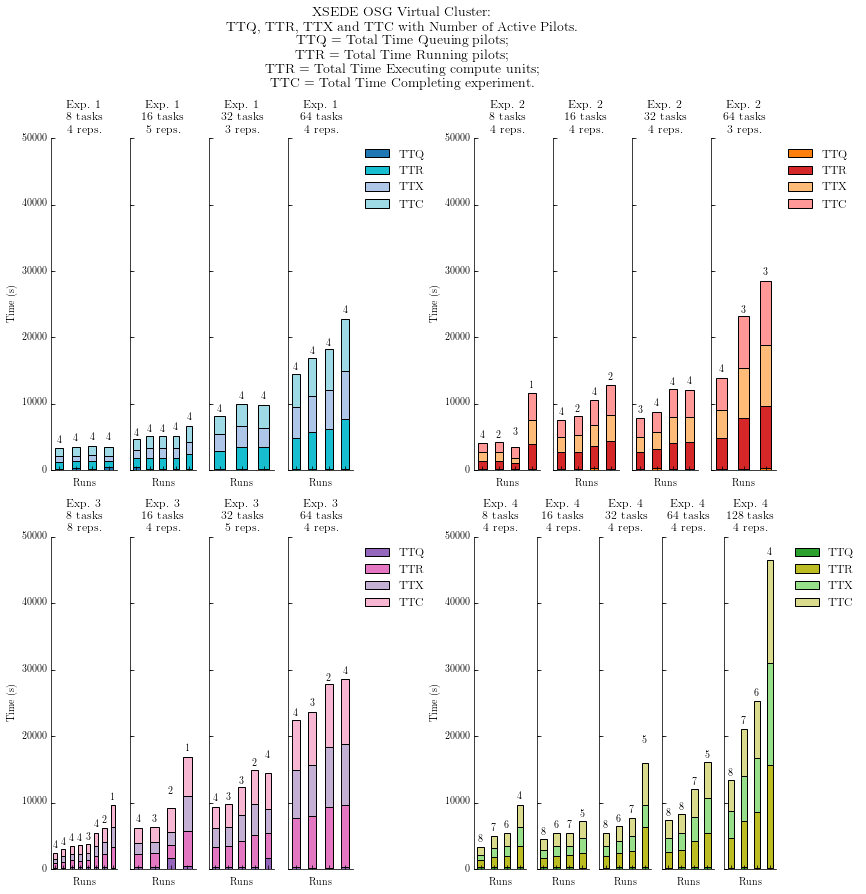

In [27]:
fig = plt.figure(figsize=(13,14))

title = 'XSEDE OSG Virtual Cluster'
subtitle = 'TTQ, TTR, TTX and TTC with Number of Active Pilots'
defs = {'ttq': 'TTQ = Total Time Queuing pilots',
        'ttr': 'TTR = Total Time Running pilots',
        'ttx': 'TTR = Total Time Executing compute units',
        'ttc': 'TTC = Total Time Completing experiment'}

fig.suptitle('%s:\n%s.\n%s;\n%s;\n%s;\n%s.' % (title, 
                                      subtitle, 
                                      defs['ttq'], 
                                      defs['ttr'], 
                                      defs['ttx'], 
                                      defs['ttc']), fontsize=14)

gs = []
grid  = gridspec.GridSpec(2, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[2]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[3]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        if not sessions[ (sessions['experiment'] == exp) & 
                 (sessions['nunits'] == nun) ].empty:
            ttq_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                          (sessions['nunits'] == nun) ].sort_values('TTC'))

# colors = {'exp1': [tableau20[0] ,tableau20[8] ,tableau20[9],tableau20[1]],
#           'exp2': [tableau20[2] ,tableau20[6] ,tableau20[7],tableau20[3]],
#           'exp3': [tableau20[10],tableau20[14],tableau20[15],tableau20[11]],
#           'exp4': [tableau20[4] ,tableau20[12],tableau20[13],tableau20[17]]}

colors = {'exp1': [tableau20[0] ,tableau20[18],tableau20[1] ,tableau20[19]],
          'exp2': [tableau20[2] ,tableau20[6] ,tableau20[3] ,tableau20[7] ],
          'exp3': [tableau20[8] ,tableau20[12],tableau20[9] ,tableau20[13]],
          'exp4': [tableau20[4] ,tableau20[16],tableau20[5] ,tableau20[17]],
          'exp5': [tableau20[10],tableau20[14],tableau20[11],tableau20[15]]}

nun_exp = []
nun_exp.append(len(sessions[sessions['experiment'] == 'exp1']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp2']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp3']['nunits'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp4']['nunits'].sort_values().unique()))

ax = []
i  = 0
while(i < len(ttq_subplots)):
    for gn in range(4):
        for gc in range(nun_exp[gn]):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Exp. %s\n%s tasks\n%s reps.' % (experiment[3], ntasks, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['TT_PILOT_LRMS_QUEUING', 
                     'TT_PILOT_LRMS_RUNNING',
                     'TT_UNIT_AGENT_EXECUTING',
                     'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Runs')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7 or i == 16:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 7 or i == 3 or i == 11:
                ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(2.25, 1))
            elif i == 16:
                ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(2.70, 1))
            else:
                ax[i].get_legend().set_visible(False)
                
            # Add labels with number of pilots per session.
            rects = ax[i].patches
            labels = [int(l) for l in session['npilot_active']]
            for rect, label in zip(rects[-repetitions:], labels):
                height = rect.get_height()
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           (height*3), label, ha='center', 
                           va='bottom')

            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttq_ttr_ttx_ttc_npactive_nunits.pdf', dpi=600, bbox_inches='tight')

The diagram confirms the similarity between the size of TTR and TTX. More analytically:

In [28]:
sessions[['TT_PILOT_LRMS_RUNNING', 'TT_UNIT_AGENT_EXECUTING']].describe()

,TT_PILOT_LRMS_RUNNING,TT_UNIT_AGENT_EXECUTING
count,72.000000,72.000000
mean,3490.056229,3301.837846
std,2698.278110,2685.132010
min,697.522100,665.675400
25%,1631.464550,1446.410950
50%,2593.843550,2560.194050
75%,4453.639975,4005.900000
max,15388.901700,15361.804200


We now have to characterize the variation among TTX of the runs with the same number of CUs and between the two experiments. We plot just TTX focusing on these variations.

IndexError: index 0 is out of bounds for axis 0 with size 0

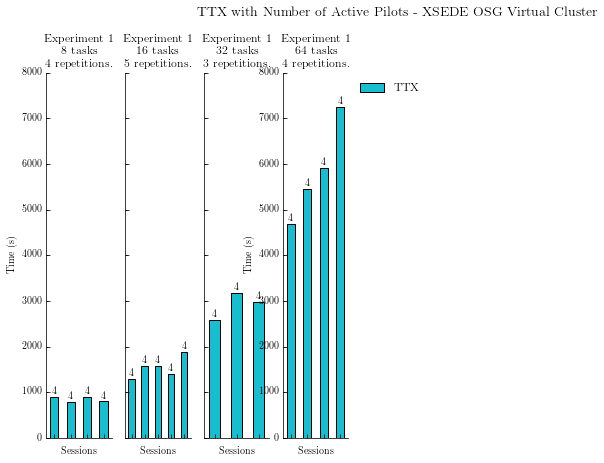

In [29]:
fig = plt.figure(figsize=(13,7))
fig.suptitle('TTX with Number of Active Pilots - XSEDE OSG Virtual Cluster', fontsize=14)

gs = []
grid  = gridspec.GridSpec(1, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        ttq_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                      (sessions['nunits'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[18]],
          'exp2': [tableau20[10]]}

ax = []
i  = 0
while(i<8):
    for gn in range(2):
        for gc in range(4):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Experiment %s\n%s tasks\n%s repetitions.' % (experiment[3], ntasks, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['TT_UNIT_AGENT_EXECUTING']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Sessions')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 7 or i == 3:
                ax[i].legend(labels=['TTX'], bbox_to_anchor=(2.25, 1))
            else:
                ax[i].get_legend().set_visible(False)
                
            # Add labels with number of pilots per session.
            rects = ax[i].patches
            labels = [int(l) for l in session['npilot_active']]
            for rect, label in zip(rects[-repetitions:], labels):
                height = rect.get_height()
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           height+0.5, label, ha='center', 
                           va='bottom')

            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttx_npactive_nunits.pdf', dpi=600, bbox_inches='tight')

We notice lage variations both within and across experiments. Specifically:

In [ ]:
ttx_stats = {}

for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        tag = exp+'_'+str(int(nun))
        ttx_stats[tag] = sessions[ (sessions['experiment'] == exp) & 
                                   (sessions['nunits'] == nun) ]['TT_UNIT_AGENT_EXECUTING'].describe()

ttx_compare = pd.DataFrame(ttx_stats)

sort_cols_runs = ['exp1_8' , 'exp2_8' , 'exp1_16', 'exp2_16', 
                  'exp1_32', 'exp2_32', 'exp1_64', 'exp2_64']
sort_cols_exp  = ['exp1_8' , 'exp1_16', 'exp1_32', 'exp1_64', 
                  'exp2_8',  'exp2_16', 'exp2_32', 'exp2_64']

ttx_compare_runs = ttx_compare.reindex_axis(sort_cols_runs, axis=1)
ttx_compare_exp  = ttx_compare.reindex_axis(sort_cols_exp,  axis=1)

ttx_compare_exp.round(2)

In [ ]:
std_mean = (ttx_compare_exp.loc['std']/ttx_compare_exp.loc['mean'])*100
std_mean.round(2)

Variation within Experiment 1 is between 7 and 18% of mean, almost proportionally increasing with the increasing of the number of unit executed. Variation in Experiment 2 is more pronounced, ranging from 25 to 78% of the mean. Clearly, these values are not indicative. 

While our analysis showed that this difference is due to the varying number of active pilots in Experiment 2, the relative uniformity of Experiment 1 may be _also_ a byproduct of a reduced functionality of RP that limited the number of resources in which the experiment was able to run successfully. Experiment 1 failed when any of the pilots failed while in Experiment 2, failures where limited to pilots, without affecting the overall execution.

## Concurrency

Finally, another element that should be considered is the impact of RP overheads on the execution of CUs. While the comparison between TTR and TTX excluded major overheads outside TTX, the averarages between the two parameters show that TTR grown bigger than TTX proportionally to the increase of the number of CU executed. This can be measured by looking at the degree of concurrency of CU executions across pilots. 

Here we plot this degree only for 64 CUs comparing both exp1 and exp2 runs.

In [ ]:
from collections import OrderedDict

cTTXs = OrderedDict()
ncu = 64

ss = sessions[sessions['nunits'] == ncu].sort_values(['experiment','TTC'])['session']

for s in ss:
    cTTXs[s._sid] = s.filter(etype='unit').concurrency(state=['AGENT_EXECUTING','AGENT_STAGING_OUTPUT_PENDING'],
                                                       sampling=1)

for sid, cTTX in cTTXs.iteritems():
    title = 'Degree of Concurrent Execution of %s CUs - XSEDE OSG Virtual Cluster\nSession %s' % (ncu, sid)
    x = [x[0] for x in cTTX]
    y = [y[1] for y in cTTX]

    color = tableau20[2]
    if 'ming' in sid:
        color = tableau20[0]
    
    fig, ax = fig_setup()
    fig.suptitle(title, fontsize=14)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Number of CU')
    display(ax.plot(x, y, marker='.',  linestyle='', color=color))

Experiment 2 shows better concurrency than Experiment 1. This might be due to the evolution of the RADICAL Pilot code or more performant resources used by the runs of Experiment 2. These data shows at least three elements that need further development:

* We lack information on what resource each pilot has been running. Without this information we cannot make statistical inferences about some of the durations we measure.
* RADICAL Pilot overheads affect experimental measures at both global (see state models) and local level (see concurrency overheads). Their characterization and, in case, normalization is required by every experiment and need to be considered a first citizen of analytics.
* Experiments are potentially affected by small differences in the RADICAL Pilot code base. This would require the use of a stable RADICAL Pilot code base across all the experiment computational campaign.  

## Time execution (Tx)

Overall, our analysis confirms that the heterogeneity of OSG resources affects TTX and that TTQ has a marginal impact. The following step is trying to characterize statistically the effect of resource heterogeneity on TTX. We begin this characterization by looking at the time that each unit takes to execute on a OSG resource (Tx). 

Each CU has the same computing requirements. Therefore, we can aggregate their analysis across experiments. Note that each unit executed on only and only one pilot so the number of pilot that becomes active have no bearing on the units' Tx.

In [ ]:
# Model of unit durations.
udm = {'UNIT_UMGR_SCHEDULING'   : ['NEW'                         , 'UMGR_SCHEDULING_PENDING'],
       'UNIT_UMGR_BINDING'      : ['UMGR_SCHEDULING_PENDING'     , 'UMGR_SCHEDULING'],
       'IF_UMGR_SCHEDULING'     : ['UMGR_SCHEDULING'             , 'UMGR_STAGING_INPUT_PENDING'], 
       'IF_UMGR_QUEING'         : ['UMGR_STAGING_INPUT_PENDING'  , 'UMGR_STAGING_INPUT'],
       #'IF_AGENT_SCHEDULING'    : ['UMGR_STAGING_INPUT'          , 'AGENT_STAGING_INPUT_PENDING'],  
       'IF_AGENT_QUEUING'       : ['AGENT_STAGING_INPUT_PENDING' , 'AGENT_STAGING_INPUT'], 
       'IF_AGENT_TRANSFERRING'  : ['AGENT_STAGING_INPUT'         , 'AGENT_SCHEDULING_PENDING'],
       'UNIT_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING'    , 'AGENT_SCHEDULING'],
       'UNIT_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING'            , 'AGENT_EXECUTING_PENDING'], 
       'UNIT_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING'     , 'AGENT_EXECUTING'], 
       'UNIT_AGENT_EXECUTING'   : ['AGENT_EXECUTING'             , 'AGENT_STAGING_OUTPUT_PENDING'], 
       'OF_AGENT_QUEUING'       : ['AGENT_STAGING_OUTPUT_PENDING', 'AGENT_STAGING_OUTPUT'], 
       #'OF_UMGR_SCHEDULING'     : ['AGENT_STAGING_OUTPUT'        , 'UMGR_STAGING_OUTPUT_PENDING'],
       'OF_UMGR_QUEUING'        : ['UMGR_STAGING_OUTPUT_PENDING' , 'UMGR_STAGING_OUTPUT'],
       'OF_UMGR_TRANSFERRING'   : ['UMGR_STAGING_OUTPUT'         , 'DONE']}

# DataFrame structure for pilot durations. 
uds = { 'pid': [],
        'sid': [],
        'experiment' : [],
        'UNIT_UMGR_SCHEDULING'   : [],
        'UNIT_UMGR_BINDING'      : [],
        'IF_UMGR_SCHEDULING'     : [], 
        'IF_UMGR_QUEING'         : [],
        'IF_AGENT_SCHEDULING'    : [],
        'IF_AGENT_QUEUING'       : [], 
        'IF_AGENT_TRANSFERRING'  : [],
        'UNIT_AGENT_QUEUING'     : [],
        'UNIT_AGENT_SCHEDULING'  : [], 
        'UNIT_AGENT_QUEUING_EXEC': [], 
        'UNIT_AGENT_EXECUTING'   : [], 
        'OF_AGENT_QUEUING'       : [], 
        'OF_UMGR_SCHEDULING'     : [],
        'OF_UMGR_QUEUING'        : [],
        'OF_UMGR_TRANSFERRING'   : []}

# Calculate the duration for each state of each 
# pilot of each run and Populate the DataFrame 
# structure.
for sid in sessions[['session', 'experiment']].index:
    s = sessions.ix[sid, 'session'].filter(etype='unit', inplace=False)
    for u in s.list('uid'):
        sf = s.filter(uid=u, inplace=False)
        uds['pid'].append(u)
        uds['sid'].append(sid)
        uds['experiment'].append(sessions.ix[sid, 'experiment'])
        for d in udm.keys():
#             print sid
#             print udm[d]
            if (not sf.timestamps(state=udm[d][0]) or 
                not sf.timestamps(state=udm[d][1])):
                pds[d].append(None)
                print udm[d]
                continue
#             print sf.timestamps(state=udm[d][0])
#             print sf.timestamps(state=udm[d][1])
            uds[d].append(sf.duration(udm[d]))

# Populate the DataFrame. We have empty lists 
units = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in uds.iteritems()]))

display(units.head(3))
display(units.tail(3))

Note the NaN value for `IF_AGENT_SCHEDULING` and `OF_UMGR_SCHEDULING`. The timestamp of these states is broken in the RADICAL Pilot branch used for this experiments. Without analytics it would be difficult to spot and/or understand the error.

## Statistics

We now have two set of measures that we can use to do some statistics. 

### Descriptive
#### Measures of Center
* mean ($\mu$)
* standard error of the mean (SEM) 
* median 
* mode

In [ ]:
def measures_of_center(durations):
    m = {}
    m['mu']     = np.mean(durations)         # Mean value of the data
    
    # standard error of the mean. Quantifies how 
    # precisely we know the true mean of the 
    # population. It takes into account both the 
    # value of the SD and the sample size. SEM
    # gets smaller as your samples get larger: 
    # precision of the mean gets higher with the
    # sample size.
    m['sem']    = sps.sem(durations)         
    
    # Are there extremes in our dataset? Compare 
    # to the mean. 
    m['median'] = np.median(durations)
    
    # What value occours most often?
    m['mode']   = sps.mstats.mode(durations)

    return m

Txs      = units['UNIT_AGENT_EXECUTING']
Txs_exp1 = units[ units['experiment'] == 'exp1']['UNIT_AGENT_EXECUTING']
Txs_exp2 = units[ units['experiment'] == 'exp2']['UNIT_AGENT_EXECUTING']

Txs      = sorted(Txs)
Txs_exp1 = sorted(Txs_exp1)
Txs_exp2 = sorted(Txs_exp2)

Tx_measures = measures_of_center(Txs)
Tx_measures_exp1 = measures_of_center(Txs_exp1)
Tx_measures_exp2 = measures_of_center(Txs_exp2)

print 'Tx'
pprint.pprint(Tx_measures)
print '\nTx_exp1'
pprint.pprint(Tx_measures_exp1)
print '\nTx_exp2'
pprint.pprint(Tx_measures_exp2)

#### Measures of Spread

* range
* percentiles
* interquartile (IRQ)
* variance
* standard deviation ($\sigma$)
* median absolute deviation (MAD)

In [ ]:
def measures_of_spread(durations):
    m = {}
    m['range'] = max(durations)-min(durations)
    m['min'], m['q1'], m['q2'], m['q3'], m['max'] = np.percentile(durations, [0,25,50,75,100])
    m['irq'] = m['q3'] - m['q1']
    m['var'] = np.var(durations)
    m['std'] = np.std(durations)
    m['mad'] = sm.robust.scale.mad(durations)

    return m

print "Tx"
pprint.pprint(measures_of_spread(Txs))
print "\nTx exp1"
pprint.pprint(measures_of_spread(Txs_exp1))
print "\nTx exp2"
pprint.pprint(measures_of_spread(Txs_exp2))

plots = [Txs, Txs_exp1, Txs_exp2]

fig, ax = fig_setup()
fig.suptitle('Distribution of Tx for Experiment 1 and 2', fontsize=14)
ax.set_ylabel('Time (s)')
bp = ax.boxplot(plots, labels=['Tx', 'Tx exp1', 'Tx exp2'])#, showmeans=True, showcaps=True)

bp['boxes'][0].set( color=tableau20[8] )
bp['boxes'][1].set( color=tableau20[0] )
bp['boxes'][2].set( color=tableau20[2] )

plt.savefig('figures/osg_cu_spread_box.pdf', dpi=600, bbox_inches='tight')

# - Mann-Whitney-Wilcoxon (MWW) RankSum test: determine 
#   whether two distributions are significantly 
#   different or not. Unlike the t-test, the RankSum 
#   test does not assume that the data are normally 
#   distributed. How do we interpret the difference?
x = np.linspace(min(Txs),max(Txs),len(Txs))
Txs_pdf = mlab.normpdf(x, Tx_measures['mu'], Tx_measures['std'])
z_stat, p_val = sps.ranksums(Txs, Txs_pdf)

## Skewness and Kurtosis

In [ ]:
Tx_measures['skew'] = sps.skew(Txs, bias=True)
Tx_measures['kurt'] = sps.kurtosis(Txs)

u_skew_test = sps.skewtest(Txs)
u_kurt_test = sps.kurtosistest(Txs)

print Tx_measures['skew']
print Tx_measures['kurt']

print u_skew_test
print u_kurt_test

metric      = 'T_x'
description = 'Histogram of $%s$' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures['mu'], Tx_measures['std'], Tx_measures['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, patches = ax.hist(Txs, bins='fd',
        normed=1,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[8], 
        color=tableau20[9])

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
# ax.set_xlim(150, 700)
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('figures/osg_cu_spread_hist.pdf', dpi=600, bbox_inches='tight')

In [ ]:
Tx_measures_exp1['skew'] = sps.skew(Txs, bias=True)
Tx_measures_exp1['kurt'] = sps.kurtosis(Txs)

u_skew_test = sps.skewtest(Txs)
u_kurt_test = sps.kurtosistest(Txs)

print Tx_measures_exp1['skew']
print Tx_measures_exp1['kurt']

print u_skew_test
print u_kurt_test

metric      = 'T_x_exp1'
description = 'Histogram of $%s$' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp1)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp1['mu'], Tx_measures_exp1['std'], Tx_measures_exp1['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, patches = ax.hist(Txs_exp1, bins='fd',
        normed=1,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[0], 
        color=tableau20[1])

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
# ax.set_xlim(150, 700)
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('figures/osg_exp1_cu_spread_hist.pdf', dpi=600, bbox_inches='tight')

In [ ]:
Tx_measures_exp2['skew'] = sps.skew(Txs, bias=True)
Tx_measures_exp2['kurt'] = sps.kurtosis(Txs)

u_skew_test = sps.skewtest(Txs)
u_kurt_test = sps.kurtosistest(Txs)

print Tx_measures_exp2['skew']
print Tx_measures_exp2['kurt']

print u_skew_test
print u_kurt_test

metric      = 'T_x_exp2'
description = 'Histogram of $%s$' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp2)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp2['mu'], Tx_measures_exp2['std'], Tx_measures_exp2['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, patches = ax.hist(Txs_exp2, bins='fd',
        normed=1,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[2], 
        color=tableau20[3])

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
# ax.set_xlim(150, 700)
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('figures/osg_exp2_cu_spread_hist.pdf', dpi=600, bbox_inches='tight')

In [ ]:
# - Fit to the normal distribution: fit the empirical 
#   distribution to the normal for comparison purposes.    
(f_mu, f_sigma) = sps.norm.fit(Txs)
(f_mu_exp1, f_sigma_exp1) = sps.norm.fit(Txs_exp1)
(f_mu_exp2, f_sigma_exp2) = sps.norm.fit(Txs_exp2)

# sample_pdf = np.linspace(min(Txs),max(Txs), len(Txs))
sample_pdf = np.linspace(0,max(Txs), len(Txs))
sample_pdf_exp1 = np.linspace(0,max(Txs_exp1), len(Txs_exp1))
sample_pdf_exp2 = np.linspace(0,max(Txs_exp2), len(Txs_exp2))

In [ ]:
metric      = 'T_x'
description = 'Histogram of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures['mu'], Tx_measures['std'], Tx_measures['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, p = ax.hist(Txs, bins='fd',
        normed=True,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[8], 
        color=tableau20[9])

pdf = mlab.normpdf(sample_pdf, f_mu, f_sigma)
print min(pdf)
print max(pdf)

ax.plot(sample_pdf, 
        pdf, 
        label="$\phi$", 
        color=tableau20[6])

# ax.fill_between(bins, 
#         sample_pdf,
#         color=tableau20[1],
#         alpha=0.25)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.set_xlim(min(sample_pdf), max(sample_pdf))
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('osg_cu_spread_pdf.pdf', dpi=600, bbox_inches='tight')

In [ ]:
metric      = 'T_x_exp1'
description = 'Histogram of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp1)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp1['mu'], 
                                                           Tx_measures_exp1['std'], 
                                                           Tx_measures_exp1['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, p = ax.hist(Txs_exp1, bins='fd',
        normed=True,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[0], 
        color=tableau20[1])

pdf_exp1 = mlab.normpdf(sample_pdf_exp1, f_mu_exp1, f_sigma_exp1)
print min(pdf_exp1)
print max(pdf_exp1)

ax.plot(sample_pdf_exp1, 
        pdf_exp1, 
        label="$\phi$", 
        color=tableau20[6])

# ax.fill_between(bins, 
#         sample_pdf,
#         color=tableau20[1],
#         alpha=0.25)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.set_xlim(min(sample_pdf_exp1), max(sample_pdf_exp1))
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('osg_exp1_cu_spread_pdf.pdf', dpi=600, bbox_inches='tight')

In [ ]:
metric      = 'T_x Experiment 2'
description = 'Histogram of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp2)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp2['mu'], 
                                                           Tx_measures_exp2['std'], 
                                                           Tx_measures_exp2['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, p = ax.hist(Txs_exp2, bins='fd',
        normed=True,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[2], 
        color=tableau20[3])

pdf_exp2 = mlab.normpdf(sample_pdf_exp2, f_mu_exp2, f_sigma_exp2)
print min(pdf_exp2)
print max(pdf_exp2)

ax.plot(sample_pdf_exp2, 
        pdf_exp2, 
        label="$\phi$", 
        color=tableau20[6])

# ax.fill_between(bins, 
#         sample_pdf,
#         color=tableau20[1],
#         alpha=0.25)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.set_xlim(min(sample_pdf_exp2), max(sample_pdf_exp2))
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('osg_exp2_cu_spread_pdf.pdf', dpi=600, bbox_inches='tight')

In [ ]:
# Values for analytical pdf
sample_pdf = np.random.normal(loc=f_mu, scale=f_sigma, size=len(Txs))

metric      = 'T_x'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures['mu'], Tx_measures['std'], Tx_measures['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

# fig = plt.figure()
# ax = fig.add_subplot(111)  
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)  
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 

ax = fig_setup()

n, bins, p = ax.hist(Txs, 
        bins='fd',
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[8], 
        color=tableau20[9],
        alpha=0.75)

ax.hist(sample_pdf, 
        bins='fd', 
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$cmd$",
        edgecolor=tableau20[6], 
        color=tableau20[7], 
        alpha=0.25)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_cu_cumulative_hist.pdf', dpi=600, bbox_inches='tight')

In [ ]:
# Values for analytical pdf
sample_pdf_exp1 = np.random.normal(loc=f_mu_exp1, scale=f_sigma_exp1, size=len(Txs_exp1))

metric      = 'T_x Experiment 1'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp1['mu'], 
                                                           Tx_measures_exp1['std'], 
                                                           Tx_measures_exp1['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

# fig = plt.figure()
# ax = fig.add_subplot(111)  
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)  
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 

ax = fig_setup()

n, bins, p = ax.hist(Txs_exp1, 
        bins='fd',
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[0], 
        color=tableau20[1],
        alpha=0.75)

ax.hist(sample_pdf_exp1, 
        bins='fd', 
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$cmd$",
        edgecolor=tableau20[6], 
        color=tableau20[7], 
        alpha=0.25)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_exp1_cu_cumulative_hist.pdf', dpi=600, bbox_inches='tight')

In [ ]:
# Values for analytical pdf
sample_pdf_exp2 = np.random.normal(loc=f_mu_exp2, scale=f_sigma_exp2, size=len(Txs_exp2))

metric      = 'T_x Experiment 1'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp2['mu'], 
                                                           Tx_measures_exp2['std'], 
                                                           Tx_measures_exp2['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, p = ax.hist(Txs_exp2, 
        bins='fd',
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[2], 
        color=tableau20[3],
        alpha=0.75)

ax.hist(sample_pdf_exp2, 
        bins='fd', 
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$cmd$",
        edgecolor=tableau20[6], 
        color=tableau20[7], 
        alpha=0.25)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_exp2_cu_cumulative_hist.pdf', dpi=600, bbox_inches='tight')

In [ ]:
Txs_np = np.array(Txs)

# Cumulative samples
Txs_sum = np.cumsum(np.ones(Txs_np.shape))/len(Txs)

# Values for analytical cdf
sample_cdf = np.linspace(0,max(Txs), len(Txs))

metric      = 'T_x'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures['mu'], Tx_measures['std'], Tx_measures['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

# fig = plt.figure()
# ax = fig.add_subplot(111)  
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)  
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 

ax = fig_setup()

ax.plot(sample_cdf, 
        sps.norm.cdf(sample_cdf, f_mu, f_sigma), 
        label="cdf",
        color=tableau20[6])

ax.step(Txs, 
        Txs_sum,
        label="$T_x$",
        where='post',
        color=tableau20[8])

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_cu_cumulative_plot.pdf', dpi=600, bbox_inches='tight')

In [ ]:
Txs_np_exp1 = np.array(Txs_exp1)

# Cumulative samples
Txs_sum_exp1 = np.cumsum(np.ones(Txs_np_exp1.shape))/len(Txs_exp1)

# Values for analytical cdf
sample_cdf_exp1 = np.linspace(0,max(Txs_exp1), len(Txs_exp1))

metric      = 'T_x Experiment 1'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp1)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp1['mu'], 
                                                           Tx_measures_exp1['std'], 
                                                           Tx_measures_exp1['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

# fig = plt.figure()
# ax = fig.add_subplot(111)  
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)  
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 

ax = fig_setup()

ax.plot(sample_cdf_exp1, 
        sps.norm.cdf(sample_cdf_exp1, f_mu_exp1, f_sigma_exp1), 
        label="cdf",
        color=tableau20[6])

ax.step(Txs_exp1, 
        Txs_sum_exp1,
        label="$T_x$",
        where='post',
        color=tableau20[0])

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_exp1_cu_cumulative_plot.pdf', dpi=600, bbox_inches='tight')

In [ ]:
Txs_np_exp2 = np.array(Txs_exp2)

# Cumulative samples
Txs_sum_exp2 = np.cumsum(np.ones(Txs_np_exp2.shape))/len(Txs_exp2)

# Values for analytical cdf
sample_cdf_exp2 = np.linspace(0,max(Txs_exp2), len(Txs_exp2))

metric      = 'T_x Experiment 2'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp2)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp2['mu'], 
                                                           Tx_measures_exp2['std'], 
                                                           Tx_measures_exp2['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

# fig = plt.figure()
# ax = fig.add_subplot(111)  
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)  
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 

ax = fig_setup()

ax.plot(sample_cdf_exp2, 
        sps.norm.cdf(sample_cdf_exp2, f_mu_exp2, f_sigma_exp2), 
        label="cdf",
        color=tableau20[6])

ax.step(Txs_exp2, 
        Txs_sum_exp2,
        label="$T_x$",
        where='post',
        color=tableau20[2])

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_exp2_cu_cumulative_plot.pdf', dpi=600, bbox_inches='tight')